**Import and install Required Libraries**

In [34]:
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
# Import required libraries

import keras                                   # Deep learning library
import string                                  # Library for string constants and operations
import re                                      # Library for regular expressions
import pandas as pd                            # Library for data manipulation and analysis


from keras.models import Sequential            # Keras model type for creating models layer-by-layer
from numpy import array, argmax, random, take  # Library for multi-dimensional arrays and matrices
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed  # Keras layers for neural networks
from keras.callbacks import ModelCheckpoint   # Keras callback for saving the model after every epoch
from keras.preprocessing.text import Tokenizer # Keras class for text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences # Keras function for padding sequences
from keras.models import load_model            # Keras function for loading a saved model
from keras import optimizers                   # Keras module for optimization algorithms

import matplotlib.pyplot as plt               # Library for creating data visualizations
#%matplotlib inline                             # Command for displaying plots inline in Jupyter notebooks
# Set option to display maximum column width in pandas
pd.set_option('display.max_colwidth', 200)


**Reading the Data**

We have a text file named deu.txt which has the Engilsh-German sentences pairs. We have to first read the file using the function defined below.

In [36]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now we will define a function to split this file into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences in order to view the Data we have

In [37]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

The data "deu.txt" in your working directory of the github

In [38]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The dataset we're working with contains over 150,000 sentence pairs, but for the purposes of reducing the training time of our model, we'll be using only the first 100,000 pairs. Feel free to adjust this number based on your system's computational power.

In [39]:
deu_eng = deu_eng[:150000,:]

**Start Pre-processing**

To clean the text we need to look at the data and then decide what approach should we take for pre-processing.

In [40]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['The shirts are dry.', 'Die Hemden sind trocken.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #462914 (lukaszpp) & #1703641 (Esperantostern)'],
       ['The signal was red.', 'Das Signal war rot.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #268855 (CK) & #810390 (Manfredo)'],
       ['The sky brightened.', 'Der Himmel hellte sich auf.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #']], dtype='<U106')

Removing all punctuation marks from the German and English sentences in the deu_eng array. It first selects the first column of the array which contains the German sentences using deu_eng[:,0], and applies the translate() method to remove all punctuation marks from each sentence. Similarly, it selects the second column of the array which contains the corresponding English sentences using deu_eng[:,1], and removes the punctuation marks from them as well. This is done to ensure that the model focuses on the language content of the sentences rather than the punctuation used.

In [41]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [42]:
deu_eng #Display

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['The shirts are dry', 'Die Hemden sind trocken',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #462914 (lukaszpp) & #1703641 (Esperantostern)'],
       ['The signal was red', 'Das Signal war rot',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #268855 (CK) & #810390 (Manfredo)'],
       ['The sky brightened', 'Der Himmel hellte sich auf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #']], dtype='<U106')

Converting all the sentences in the deu_eng array to lowercase. It iterates through each row in the array using a for loop and converts the source sentence (German) to lowercase using the lower() function and then assigns it back to the same position in the array. Similarly, it converts the target sentence (English) to lowercase and assigns it back to the same position in the array. This is done to ensure that the model does not treat the same words with different capitalizations as different words.

In [43]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [44]:
deu_eng #Display

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['the shirts are dry', 'die hemden sind trocken',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #462914 (lukaszpp) & #1703641 (Esperantostern)'],
       ['the signal was red', 'das signal war rot',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #268855 (CK) & #810390 (Manfredo)'],
       ['the sky brightened', 'der himmel hellte sich auf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #']], dtype='<U106')

**Text to Sequence Conversion**

In order to prepare our data for a Seq2Seq model, we need to convert both the input and output sentences into fixed-length integer sequences. But before we do that, let's visualize the length of the sentences. To do this, we'll create two separate lists - one for English sentences and one for German sentences - to capture the lengths of all the sentences in each language.

In [45]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [46]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

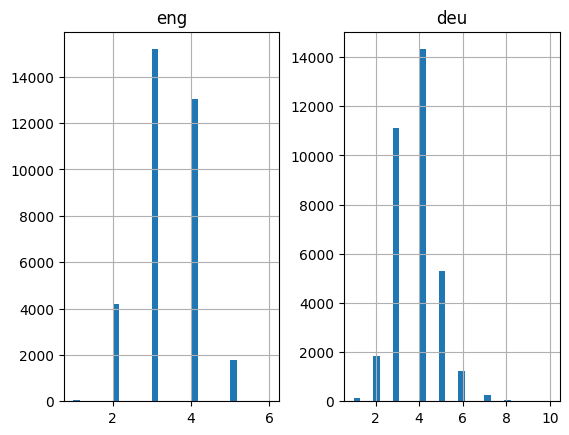

In [47]:
length_df.hist(bins = 30)
plt.show()

After visualizing the lengths of the German and English sentences, we found that the maximum length of German sentences is 11 and the maximum length of English phrases is 8.

To prepare our text data for modeling, we'll use Keras's Tokenizer() class to vectorize our sentences into sequences of integers. We'll then pad these sequences with zeros to make them all the same length, ensuring compatibility with our Seq2Seq model.

In [48]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [49]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4972


In [50]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 7933


Next, we have a function that prepares the sequences for modeling. This function will also perform padding to ensure all sequences have the same length, with the maximum length determined by the longest sentence in each language as mentioned earlier

In [51]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

**Model Building**

To train and evaluate our model, we'll now split our data into training and testing sets. We'll use the training set for model training and the testing set for model evaluation

In [52]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

Now, we'll proceed to encode our sentences. For the purposes of our Seq2Seq model, we'll encode the German sentences as the input sequences and the English sentences as the target sequences. We'll perform this encoding process for both our train and test datasets.

In [53]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [54]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Finally, it's time to define the architecture of our Seq2Seq model! For the encoder, we'll use an Embedding layer and an LSTM layer. For the decoder, we'll use another LSTM layer followed by a Dense layer. This architecture will enable us to effectively translate German sentences into English sentences.

In [55]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In this particular model, we'll be using the RMSprop optimizer. This is a popular choice for recurrent neural networks like ours, as it has been shown to work well for this type of architecture

In [56]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


This code is training the model using the training data, with the aim of minimizing the loss function (sparse categorical crossentropy). It does this over 30 epochs, using a batch size of 512. It also saves the best model according to the validation loss metric to a file named 'model.filetocheck'.

In [57]:
filename = 'model.file2check'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=50, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/50
42/43 [============================>.] - ETA: 0s - loss: 3.3464
Epoch 1: val_loss improved from inf to 2.66740, saving model to model.file2check


43/43 [==============================] - 38s 606ms/step - loss: 3.3331 - val_loss: 2.6674
Epoch 2/50
42/43 [============================>.] - ETA: 0s - loss: 2.5473
Epoch 2: val_loss improved from 2.66740 to 2.66029, saving model to model.file2check


43/43 [==============================] - 16s 385ms/step - loss: 2.5476 - val_loss: 2.6603
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 2.4485
Epoch 3: val_loss improved from 2.66029 to 2.44654, saving model to model.file2check


43/43 [==============================] - 16s 369ms/step - loss: 2.4485 - val_loss: 2.4465
Epoch 4/50
42/43 [============================>.] - ETA: 0s - loss: 2.3304
Epoch 4: val_loss improved from 2.44654 to 2.31961, saving model to model.file2check


43/43 [==============================] - 16s 389ms/step - loss: 2.3295 - val_loss: 2.3196
Epoch 5/50
42/43 [============================>.] - ETA: 0s - loss: 2.1926
Epoch 5: val_loss improved from 2.31961 to 2.23101, saving model to model.file2check


43/43 [==============================] - 17s 402ms/step - loss: 2.1910 - val_loss: 2.2310
Epoch 6/50
42/43 [============================>.] - ETA: 0s - loss: 2.0675
Epoch 6: val_loss improved from 2.23101 to 2.13689, saving model to model.file2check


43/43 [==============================] - 17s 403ms/step - loss: 2.0668 - val_loss: 2.1369
Epoch 7/50
42/43 [============================>.] - ETA: 0s - loss: 1.9618
Epoch 7: val_loss improved from 2.13689 to 2.04952, saving model to model.file2check


43/43 [==============================] - 16s 377ms/step - loss: 1.9606 - val_loss: 2.0495
Epoch 8/50
42/43 [============================>.] - ETA: 0s - loss: 1.8608
Epoch 8: val_loss improved from 2.04952 to 1.97895, saving model to model.file2check


43/43 [==============================] - 16s 388ms/step - loss: 1.8602 - val_loss: 1.9790
Epoch 9/50
42/43 [============================>.] - ETA: 0s - loss: 1.7614
Epoch 9: val_loss improved from 1.97895 to 1.90523, saving model to model.file2check


43/43 [==============================] - 16s 371ms/step - loss: 1.7604 - val_loss: 1.9052
Epoch 10/50
43/43 [==============================] - ETA: 0s - loss: 1.6693
Epoch 10: val_loss improved from 1.90523 to 1.84306, saving model to model.file2check


43/43 [==============================] - 16s 378ms/step - loss: 1.6693 - val_loss: 1.8431
Epoch 11/50
43/43 [==============================] - ETA: 0s - loss: 1.5853
Epoch 11: val_loss improved from 1.84306 to 1.80259, saving model to model.file2check


43/43 [==============================] - 16s 386ms/step - loss: 1.5853 - val_loss: 1.8026
Epoch 12/50
42/43 [============================>.] - ETA: 0s - loss: 1.5015
Epoch 12: val_loss improved from 1.80259 to 1.74678, saving model to model.file2check


43/43 [==============================] - 17s 393ms/step - loss: 1.5018 - val_loss: 1.7468
Epoch 13/50
43/43 [==============================] - ETA: 0s - loss: 1.4248
Epoch 13: val_loss improved from 1.74678 to 1.68783, saving model to model.file2check


43/43 [==============================] - 16s 376ms/step - loss: 1.4248 - val_loss: 1.6878
Epoch 14/50
42/43 [============================>.] - ETA: 0s - loss: 1.3514
Epoch 14: val_loss improved from 1.68783 to 1.66583, saving model to model.file2check


43/43 [==============================] - 16s 376ms/step - loss: 1.3515 - val_loss: 1.6658
Epoch 15/50
43/43 [==============================] - ETA: 0s - loss: 1.2809
Epoch 15: val_loss improved from 1.66583 to 1.60358, saving model to model.file2check


43/43 [==============================] - 16s 377ms/step - loss: 1.2809 - val_loss: 1.6036
Epoch 16/50
43/43 [==============================] - ETA: 0s - loss: 1.2133
Epoch 16: val_loss improved from 1.60358 to 1.59485, saving model to model.file2check


43/43 [==============================] - 16s 372ms/step - loss: 1.2133 - val_loss: 1.5949
Epoch 17/50
42/43 [============================>.] - ETA: 0s - loss: 1.1467
Epoch 17: val_loss improved from 1.59485 to 1.53281, saving model to model.file2check


43/43 [==============================] - 16s 373ms/step - loss: 1.1475 - val_loss: 1.5328
Epoch 18/50
42/43 [============================>.] - ETA: 0s - loss: 1.0837
Epoch 18: val_loss improved from 1.53281 to 1.51856, saving model to model.file2check


43/43 [==============================] - 16s 390ms/step - loss: 1.0834 - val_loss: 1.5186
Epoch 19/50
43/43 [==============================] - ETA: 0s - loss: 1.0243
Epoch 19: val_loss improved from 1.51856 to 1.48922, saving model to model.file2check


43/43 [==============================] - 16s 376ms/step - loss: 1.0243 - val_loss: 1.4892
Epoch 20/50
42/43 [============================>.] - ETA: 0s - loss: 0.9645
Epoch 20: val_loss improved from 1.48922 to 1.44293, saving model to model.file2check


43/43 [==============================] - 16s 371ms/step - loss: 0.9648 - val_loss: 1.4429
Epoch 21/50
43/43 [==============================] - ETA: 0s - loss: 0.9105
Epoch 21: val_loss improved from 1.44293 to 1.41445, saving model to model.file2check


43/43 [==============================] - 16s 387ms/step - loss: 0.9105 - val_loss: 1.4144
Epoch 22/50
42/43 [============================>.] - ETA: 0s - loss: 0.8529
Epoch 22: val_loss improved from 1.41445 to 1.39642, saving model to model.file2check


43/43 [==============================] - 17s 394ms/step - loss: 0.8529 - val_loss: 1.3964
Epoch 23/50
43/43 [==============================] - ETA: 0s - loss: 0.8012
Epoch 23: val_loss improved from 1.39642 to 1.36791, saving model to model.file2check


43/43 [==============================] - 16s 382ms/step - loss: 0.8012 - val_loss: 1.3679
Epoch 24/50
42/43 [============================>.] - ETA: 0s - loss: 0.7518
Epoch 24: val_loss improved from 1.36791 to 1.35896, saving model to model.file2check


43/43 [==============================] - 16s 379ms/step - loss: 0.7528 - val_loss: 1.3590
Epoch 25/50
43/43 [==============================] - ETA: 0s - loss: 0.7045
Epoch 25: val_loss improved from 1.35896 to 1.34542, saving model to model.file2check


43/43 [==============================] - 16s 378ms/step - loss: 0.7045 - val_loss: 1.3454
Epoch 26/50
42/43 [============================>.] - ETA: 0s - loss: 0.6588
Epoch 26: val_loss improved from 1.34542 to 1.32634, saving model to model.file2check


43/43 [==============================] - 16s 386ms/step - loss: 0.6590 - val_loss: 1.3263
Epoch 27/50
43/43 [==============================] - ETA: 0s - loss: 0.6144
Epoch 27: val_loss improved from 1.32634 to 1.29814, saving model to model.file2check


43/43 [==============================] - 16s 379ms/step - loss: 0.6144 - val_loss: 1.2981
Epoch 28/50
42/43 [============================>.] - ETA: 0s - loss: 0.5707
Epoch 28: val_loss improved from 1.29814 to 1.29572, saving model to model.file2check


43/43 [==============================] - 16s 382ms/step - loss: 0.5712 - val_loss: 1.2957
Epoch 29/50
42/43 [============================>.] - ETA: 0s - loss: 0.5323
Epoch 29: val_loss improved from 1.29572 to 1.29519, saving model to model.file2check


43/43 [==============================] - 16s 378ms/step - loss: 0.5328 - val_loss: 1.2952
Epoch 30/50
42/43 [============================>.] - ETA: 0s - loss: 0.4948
Epoch 30: val_loss improved from 1.29519 to 1.28734, saving model to model.file2check


43/43 [==============================] - 16s 378ms/step - loss: 0.4958 - val_loss: 1.2873
Epoch 31/50
42/43 [============================>.] - ETA: 0s - loss: 0.4590
Epoch 31: val_loss improved from 1.28734 to 1.27295, saving model to model.file2check


43/43 [==============================] - 15s 364ms/step - loss: 0.4592 - val_loss: 1.2730
Epoch 32/50
43/43 [==============================] - ETA: 0s - loss: 0.4243
Epoch 32: val_loss improved from 1.27295 to 1.26408, saving model to model.file2check


43/43 [==============================] - 17s 408ms/step - loss: 0.4243 - val_loss: 1.2641
Epoch 33/50
42/43 [============================>.] - ETA: 0s - loss: 0.3914
Epoch 33: val_loss improved from 1.26408 to 1.24742, saving model to model.file2check


43/43 [==============================] - 16s 378ms/step - loss: 0.3919 - val_loss: 1.2474
Epoch 34/50
43/43 [==============================] - ETA: 0s - loss: 0.3630
Epoch 34: val_loss did not improve from 1.24742
43/43 [==============================] - 2s 54ms/step - loss: 0.3630 - val_loss: 1.2654
Epoch 35/50
43/43 [==============================] - ETA: 0s - loss: 0.3336
Epoch 35: val_loss did not improve from 1.24742
43/43 [==============================] - 2s 55ms/step - loss: 0.3336 - val_loss: 1.2489
Epoch 36/50
43/43 [==============================] - ETA: 0s - loss: 0.3076
Epoch 36: val_loss did not improve from 1.24742
43/43 [==============================] - 2s 52ms/step - loss: 0.3076 - val_loss: 1.2722
Epoch 37/50
42/43 [============================>.] - ETA: 0s - loss: 0.2843
Epoch 37: val_loss improved from 1.24742 to 1.24691, saving model to model.file2check


43/43 [==============================] - 16s 372ms/step - loss: 0.2841 - val_loss: 1.2469
Epoch 38/50
42/43 [============================>.] - ETA: 0s - loss: 0.2612
Epoch 38: val_loss did not improve from 1.24691
43/43 [==============================] - 2s 53ms/step - loss: 0.2614 - val_loss: 1.2488
Epoch 39/50
42/43 [============================>.] - ETA: 0s - loss: 0.2388
Epoch 39: val_loss improved from 1.24691 to 1.23651, saving model to model.file2check


43/43 [==============================] - 16s 388ms/step - loss: 0.2393 - val_loss: 1.2365
Epoch 40/50
43/43 [==============================] - ETA: 0s - loss: 0.2223
Epoch 40: val_loss did not improve from 1.23651
43/43 [==============================] - 2s 53ms/step - loss: 0.2223 - val_loss: 1.2487
Epoch 41/50
42/43 [============================>.] - ETA: 0s - loss: 0.2007
Epoch 41: val_loss improved from 1.23651 to 1.23635, saving model to model.file2check


43/43 [==============================] - 16s 373ms/step - loss: 0.2010 - val_loss: 1.2363
Epoch 42/50
42/43 [============================>.] - ETA: 0s - loss: 0.1871
Epoch 42: val_loss did not improve from 1.23635
43/43 [==============================] - 2s 54ms/step - loss: 0.1874 - val_loss: 1.2401
Epoch 43/50
43/43 [==============================] - ETA: 0s - loss: 0.1718
Epoch 43: val_loss did not improve from 1.23635
43/43 [==============================] - 2s 54ms/step - loss: 0.1718 - val_loss: 1.2461
Epoch 44/50
43/43 [==============================] - ETA: 0s - loss: 0.1578
Epoch 44: val_loss did not improve from 1.23635
43/43 [==============================] - 2s 56ms/step - loss: 0.1578 - val_loss: 1.2688
Epoch 45/50
42/43 [============================>.] - ETA: 0s - loss: 0.1474
Epoch 45: val_loss did not improve from 1.23635
43/43 [==============================] - 2s 52ms/step - loss: 0.1479 - val_loss: 1.2584
Epoch 46/50
43/43 [==============================] - ETA: 0s -

Comparing the training loss and the validation loss.

And display a plot of the training loss and validation loss over the epochs of training.

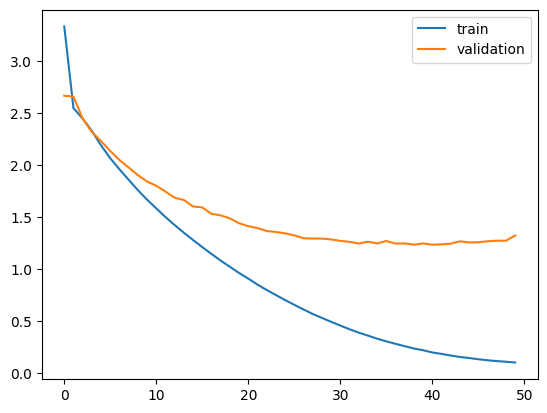

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

**Make Predictions**

Let's load the saved model to make predictions.

In [59]:
model = load_model('model.file2check')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
preds_classes = preds.argmax(axis=-1)


215/215 [==============================] - 3s 5ms/step


In [60]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [61]:
# convert predictions into text (English)
import numpy as np

preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(np.argmax(i[j]), eng_tokenizer)
        if j > 0:
            if (t == get_word(np.argmax(i[j-1]), eng_tokenizer)) or (t is None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t is None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))


In [62]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [63]:
pd.set_option('display.max_colwidth', 200)

In [64]:
pred_df.head(15)

,actual,predicted
0,i drink to relax,i remember with up
1,i ran upstairs,i ran upstairs
2,we need to know,we must to know
3,i like writing,i like something
4,he deserves more,he more
5,thats for you,this for you
6,dont judge me,dont bug me
7,be patient,be brief
8,im not ready,im not ready
9,that makes me cry,it matters to me


In [65]:
pred_df.tail(15)

,actual,predicted
6837,toms lucky,tom is
6838,tom looks drunk,tom looks drunk
6839,do you know her,do you know her
6840,ill get the wine,i read the
6841,we were soldiers,we were neighbors
6842,im on the balcony,im on at way
6843,im afraid for you,i waited up
6844,tom moved quickly,tom gained quickly
6845,listen,listen up
6846,were paying,were attack


In [66]:
pred_df.sample(15)

,actual,predicted
3212,i loved that,i wanted that
3286,tom can leave,tom can go
2565,i want to know why,i want to know
80,i love bread,i love kids
3115,try and sing,try and of me
4432,shes pregnant,she is
2219,i might be back,am i come
514,dont miss the bus,get on the bus
724,lets go now,lets go back now
4397,hug me,me
